<a href="https://colab.research.google.com/github/nasare34/EcDNet-Encoder-Corollary-Atrous-Spatial-Pyramid-Pooling-Decoder-Automated-for-Pancreas-Segmentation-/blob/main/Pancreas_segmentation_Attention_Mechanism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install albumentations

In [ ]:
!pip install tensorboard

In [ ]:
!pip install pydicom pillow torchio torch-lr-finder nibabel matplotlib tqdm albumentations


In [ ]:
!pip install pydicom

In [ ]:
#necessary imports
import cv2
from matplotlib import pyplot as plot
import numpy as np
from pathlib import Path
import tensorflow as tf
import pydicom
from google.colab import drive
from google.colab import drive
import os
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
# Function to change visibility and normalize the CT image
def changeVandN(matrix):
    Max = 500
    Min = -100
    matrix[matrix > Max] = Max
    matrix[matrix < Min] = Min

    # Normalization
    matrix = matrix - Min
    matrix = matrix / (Max - Min)
    return matrix

In [ ]:
# Function to round pixel values to 0 or 255
def round2binary(matrix):
    matrix = np.round(matrix / 255) * 255
    return matrix

# Function to round pixel values to 0 or 1
def round2binary1(matrix):
    matrix = np.round(matrix / 1) * 1
    return matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Update paths for images and masks
pancs = '/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images'
masks = '/content/drive/MyDrive/Preprocessed_pancreas_update/Masks'


In [ ]:
# Ensure directories exist and list files
try:
    panc_paths = list(Path(pancs).iterdir())
    panc_paths.sort()
    masks_paths = list(Path(masks).iterdir())
    masks_paths.sort()
except FileNotFoundError as e:
    print(f"Error: {e}")
    panc_paths, masks_paths = [], []

In [ ]:
# Collecting all image and mask paths
all_panc_paths = []
all_mask_paths = []

for path in panc_paths:
    dcm_paths = list(Path(path).iterdir())
    dcm_paths.sort()
    for count, dcms in enumerate(dcm_paths):
        all_panc_paths.append(dcms)
        if count == 184:
            break

for path in masks_paths:
    png_paths = list(Path(path).iterdir())
    png_paths.sort()
    for count, masks in enumerate(png_paths):
        all_mask_paths.append(masks)
        if count == 184:
            break

In [ ]:
# Verify if files are correctly listed
print("CT image files:", len(all_panc_paths))
print("Mask files:", len(all_mask_paths))

CT image files: 1850
Mask files: 1850


In [ ]:
# Import the pandas library
import pandas as pd

# Create a DataFrame with paths
data = pd.DataFrame({
    'pacs': [str(i) for i in all_panc_paths],
    'masks': [str(i) for i in all_mask_paths]
})

# Display the first few rows of the DataFrame
print(data.head())

                                                pacs  \
0  /content/drive/MyDrive/Preprocessed_pancreas_u...   
1  /content/drive/MyDrive/Preprocessed_pancreas_u...   
2  /content/drive/MyDrive/Preprocessed_pancreas_u...   
3  /content/drive/MyDrive/Preprocessed_pancreas_u...   
4  /content/drive/MyDrive/Preprocessed_pancreas_u...   

                                               masks  
0  /content/drive/MyDrive/Preprocessed_pancreas_u...  
1  /content/drive/MyDrive/Preprocessed_pancreas_u...  
2  /content/drive/MyDrive/Preprocessed_pancreas_u...  
3  /content/drive/MyDrive/Preprocessed_pancreas_u...  
4  /content/drive/MyDrive/Preprocessed_pancreas_u...  


In [ ]:
data

,pacs,masks
0,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...
1,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...
2,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...
3,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...
4,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...
...,...,...
1845,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...
1846,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...
1847,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...
1848,/content/drive/MyDrive/Preprocessed_pancreas_u...,/content/drive/MyDrive/Preprocessed_pancreas_u...


In [ ]:
# Slicing the DataFrame to get rows from index 370 to 399 (30 rows in total)
subset_data = data.iloc[370:400]

# Display the sliced DataFrame
print(subset_data)


                                                  pacs  \
370  /content/drive/MyDrive/Preprocessed_pancreas_u...   
371  /content/drive/MyDrive/Preprocessed_pancreas_u...   
372  /content/drive/MyDrive/Preprocessed_pancreas_u...   
373  /content/drive/MyDrive/Preprocessed_pancreas_u...   
374  /content/drive/MyDrive/Preprocessed_pancreas_u...   
375  /content/drive/MyDrive/Preprocessed_pancreas_u...   
376  /content/drive/MyDrive/Preprocessed_pancreas_u...   
377  /content/drive/MyDrive/Preprocessed_pancreas_u...   
378  /content/drive/MyDrive/Preprocessed_pancreas_u...   
379  /content/drive/MyDrive/Preprocessed_pancreas_u...   
380  /content/drive/MyDrive/Preprocessed_pancreas_u...   
381  /content/drive/MyDrive/Preprocessed_pancreas_u...   
382  /content/drive/MyDrive/Preprocessed_pancreas_u...   
383  /content/drive/MyDrive/Preprocessed_pancreas_u...   
384  /content/drive/MyDrive/Preprocessed_pancreas_u...   
385  /content/drive/MyDrive/Preprocessed_pancreas_u...   
386  /content/

In [ ]:
all_panc_paths

[PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-001.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-002.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-003.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-004.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-005.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-006.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-007.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-008.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-009.dcm'),
 PosixPath('/content/drive/MyDrive/Preprocessed_pancreas_update/CT_images/PANCREAS_0001/1-0

In [ ]:
# Slicing the lists to get elements from index 370 to 399 (30 elements in total)
images = all_panc_paths[370:400]
masks = all_mask_paths[370:400]

# Verify the sliced lists
print("Number of images:", len(images))
print("Number of masks:", len(masks))


Number of images: 30
Number of masks: 30


In [ ]:
len(all_mask_paths)

1850

In [ ]:
len(all_panc_paths)

1850

In [ ]:
# Initialize the lists
images = []
masks = []

# Loop through the specified range
for i in range(0, len(all_mask_paths)):
    panc1_image = changeVandN(pydicom.dcmread(all_panc_paths[i]).pixel_array)
    image1_resized = cv2.resize(panc1_image, (224, 224))
    panc1_mask = cv2.imread(r'{}'.format(all_mask_paths[i]))
    mask1_resized = cv2.cvtColor(cv2.resize(panc1_mask, (224, 224)), cv2.COLOR_BGR2GRAY)

    unique_values = np.unique(mask1_resized)
    if len(unique_values) > 1:
        print(f"Index {i} has mask with unique values: {unique_values}")
        images.append(image1_resized)
        masks.append(round2binary(mask1_resized))
        # You might want to break here if you only want to process the first mask with non-zero values
        # break

# Verify the results
print("Number of processed images:", len(images))
print("Number of processed masks:", len(masks))


Index 98 has mask with unique values: [  0   6  12  18  46  51  91 118 128 170 200 209 220 241 251 255]
Index 99 has mask with unique values: [  0  12  18  55  72  82  91 103 127 152 164 170 173 183 200 222 237 241
 246 255]
Index 100 has mask with unique values: [  0   6  14  18  20  46  51  55  69  72  82  91 150 164 186 200 209 212
 222 241 246 255]
Index 101 has mask with unique values: [  0   4  14  18  27  35  46  55  72  91  97 100 103 128 129 152 173 183
 200 209 220 228 235 237 251 255]
Index 102 has mask with unique values: [  0   1   4   6   9  14  18  20  35  46  64  69  82  85  91 103 127 152
 164 173 183 200 209 220 228 235 237 241 246 248 254 255]
Index 103 has mask with unique values: [  0   1  12  14  18  20  27  35  46  51  72  91 103 126 128 129 152 155
 164 173 200 212 228 237 238 246 251 255]
Index 104 has mask with unique values: [  0   6   9  18  35  46  55  69  72  82  91 103 118 128 150 152 155 164
 170 200 204 235 237 243 246 248 251 254 255]
Index 105 has mas

In [ ]:
# Convert lists to arrays
x = np.array(images)
y = np.array(masks) / 255


In [ ]:
print(len(x), len(y))


841 841


In [ ]:
y[100].shape

(224, 224)

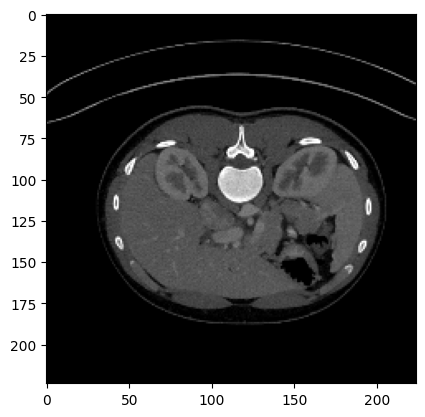

In [ ]:
plot.imshow(x[100],cmap='gray')

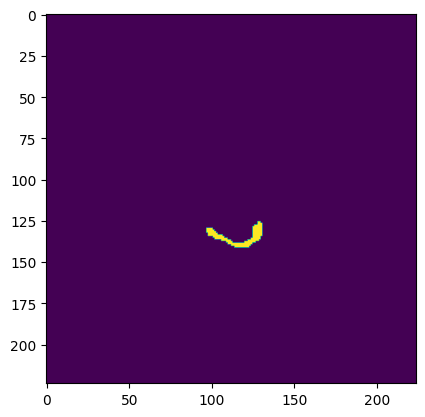

In [ ]:
plot.imshow(y[700])

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=42)


In [ ]:
# DICE METRIC
def dice_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

In [ ]:
# CASPP
def single_cell_CASPP(Input, head, sub1, sub2):
    head = keras.layers.Conv2D(kernel_size=(1,1), filters=1, strides=1, dilation_rate=head, padding='same')(Input)
    sub_1 = keras.layers.Conv2D(kernel_size=(1,1), filters=1, strides=1, dilation_rate=sub1, padding='same')(head)
    sub_2 = keras.layers.Conv2D(kernel_size=(1,1), filters=1, strides=1, dilation_rate=sub2, padding='same')(head)
    concat = keras.layers.Concatenate()([head, sub_1, sub_2])
    return concat

In [ ]:
# SMD-Block
def SMD_Block(Input, growth_factor=24):
    conv1 = keras.layers.Conv2D(growth_factor, 1, activation='relu')(Input)
    layer1 = keras.layers.Conv2D(growth_factor, 3, activation='relu', padding='same')(conv1)
    concat1 = keras.layers.Concatenate()([layer1, Input])

    conv2 = keras.layers.Conv2D(growth_factor, 1, activation='relu')(concat1)
    layer2 = keras.layers.Conv2D(growth_factor, 3, activation='relu', padding='same')(conv2)
    concat2 = keras.layers.Concatenate()([concat1, layer2])

    conv3 = keras.layers.Conv2D(growth_factor, 1, activation='relu')(concat2)
    layer3 = keras.layers.Conv2D(growth_factor, 3, activation='relu', padding='same')(conv3)
    concat3 = keras.layers.Concatenate()([concat2, layer3])

    conv4 = keras.layers.Conv2D(growth_factor, 1, activation='relu')(concat3)
    layer4 = keras.layers.Conv2D(growth_factor, 3, activation='relu', padding='same')(conv4)
    final_concat = keras.layers.Concatenate()([concat3, layer4])

    transition_layer = keras.layers.Conv2D(growth_factor, 1, activation='relu')(final_concat)

    caspp_cell1 = single_cell_CASPP(layer1, 12, 6, 3)
    caspp_cell2 = single_cell_CASPP(layer2, 9, 6, 3)
    caspp_cell3 = single_cell_CASPP(layer3, 6, 3, 1)
    caspp_cell4 = single_cell_CASPP(layer4, 3, 2, 1)
    caspp_concat = keras.layers.Concatenate()([caspp_cell1, caspp_cell2, caspp_cell3, caspp_cell4])

    output = keras.layers.Concatenate()([transition_layer])
    return output


#ATTENTION MECHANISM

In [ ]:
from tensorflow.keras import layers

class MultiHeadCrossAttention(layers.Layer):
    def __init__(self, num_heads, inter_channel):
        super(MultiHeadCrossAttention, self).__init__()
        self.num_heads = num_heads
        self.inter_channel = inter_channel
        self.attention_heads = [attention_block for _ in range(num_heads)]

    def build(self, input_shape):
        _, _, _, channels = input_shape
        self.query_conv = [layers.Conv2D(self.inter_channel, kernel_size=1, strides=1, padding='same') for _ in range(self.num_heads)]
        self.key_conv = [layers.Conv2D(self.inter_channel, kernel_size=1, strides=1, padding='same') for _ in range(self.num_heads)]
        self.value_conv = [layers.Conv2D(self.inter_channel, kernel_size=1, strides=1, padding='same') for _ in range(self.num_heads)]
        self.out_conv = layers.Conv2D(channels, kernel_size=1, strides=1, padding='same')
        self.out_bn = layers.BatchNormalization()

    def call(self, query, key, value):
        multi_head_outputs = []

        for i in range(self.num_heads):
            query_proj = self.query_conv[i](query)
            key_proj = self.key_conv[i](key)
            value_proj = self.value_conv[i](value)

            attention_out = self.attention_heads[i](query_proj, key_proj, self.inter_channel)
            multi_head_outputs.append(attention_out)

        concat_attention = layers.Concatenate(axis=-1)(multi_head_outputs)
        output = self.out_conv(concat_attention)
        output = self.out_bn(output)

        return output


In [ ]:
# Cross Multi-Head Attention Layer
num_heads = 4
inter_channel = 64

# Create an instance of the cross_attention layer
cross_attention = MultiHeadCrossAttention(num_heads, inter_channel)

# Manually build the layer to ensure the input shape is set
cross_attention.build(caspp_concat.shape)

# Call the layer with the inputs
attention_output = cross_attention(caspp_concat, caspp_concat, caspp_concat)


In [ ]:
#Major Point

In [ ]:
# Attention Layer
def attention_block(x, g, inter_channel):
    theta_x = layers.Conv2D(inter_channel, kernel_size=2, strides=2, padding='same')(x)
    phi_g = layers.Conv2D(inter_channel, kernel_size=1, strides=1, padding='same')(g)
    add_xg = layers.add([theta_x, phi_g])
    act_xg = layers.Activation('relu')(add_xg)
    psi = layers.Conv2D(1, kernel_size=1, strides=1, padding='same')(act_xg)
    sigmoid_xg = layers.Activation('sigmoid')(psi)
    upsample_psi = layers.UpSampling2D(size=(2, 2))(sigmoid_xg)
    y = layers.Multiply()([upsample_psi, x])
    result = layers.Conv2D(x.shape[-1], kernel_size=1, strides=1, padding='same')(y)
    result_bn = layers.BatchNormalization()(result)
    return result_bn



In [ ]:
from tensorflow.keras import layers, Input

# Input layer
input_shape = (256, 256, 3)
input_layer = Input(shape=input_shape)

# Input layer
input_shape = (256, 256, 3)
Input = layers.Input(shape=input_shape)

In [ ]:
# Encoder
import keras
Input = keras.layers.Input((None, None, 1))
conv1 = keras.layers.Conv2D(32, 2, 1, padding='same', activation='relu')(Input)
dense1 = SMD_Block(conv1)
d_pool1 = keras.layers.MaxPool2D((2, 2))(dense1)

conv2 = keras.layers.Conv2D(64, 2, 1, padding='same', activation='relu')(d_pool1)
norm1 = keras.layers.BatchNormalization()(conv2)
relu1 = keras.layers.ReLU()(conv2)
pool1 = keras.layers.MaxPool2D((2, 2))(relu1)

dense2 = SMD_Block(pool1)
d_pool2 = keras.layers.MaxPool2D((2, 2))(dense2)

conv3 = keras.layers.Conv2D(64, 2, 1, padding='same', activation='relu')(d_pool2)
norm2 = keras.layers.BatchNormalization()(conv3)
relu2 = keras.layers.ReLU()(conv3)
pool2 = keras.layers.MaxPool2D((2, 2))(relu2)

In [ ]:
# Bridge (CASPP)
caspp_cell1 = single_cell_CASPP(pool2, 9, 6, 3)
caspp_cell2 = single_cell_CASPP(pool2, 6, 3, 1)
caspp_cell3 = single_cell_CASPP(pool2, 3, 2, 1)
caspp_concat = keras.layers.Concatenate()([caspp_cell1, caspp_cell2, caspp_cell3])



In [ ]:


# Mount Google Drive
drive.mount('/content/drive')

# Define your SMD_Block, relu1, relu2, conv1, and caspp_concat as per your model's architecture

#  Decoder
upsample1 = keras.layers.UpSampling2D((2, 2))(caspp_concat)
uconv1 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(1, 1), padding='same', activation='relu')(upsample1)
unorm1 = keras.layers.BatchNormalization()(uconv1)
urelu1 = keras.layers.ReLU()(unorm1)
skip1 = keras.layers.Concatenate()([relu2, urelu1])

udense1 = SMD_Block(skip1)
d_up1 = keras.layers.UpSampling2D((2, 2))(udense1)

upsample2 = keras.layers.UpSampling2D((2, 2))(d_up1)
uconv2 = keras.layers.Conv2DTranspose(64, (2, 2), strides=(1, 1), padding='same', activation='relu')(upsample2)
unorm2 = keras.layers.BatchNormalization()(uconv2)
urelu2 = keras.layers.ReLU()(unorm2)  #
skip2 = keras.layers.Concatenate()([relu1, urelu2])

udense2 = SMD_Block(skip2)
d_up2 = keras.layers.UpSampling2D((2, 2))(udense2)

uconv3 = keras.layers.Conv2DTranspose(32, (2, 2), strides=(1, 1), padding='same', activation='relu')(d_up2)
skip3 = keras.layers.Concatenate()([uconv3, conv1])

coarse = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(skip3)

model = keras.models.Model(inputs=Input, outputs=coarse)
model.compile(loss='binary_focal_crossentropy', optimizer='adam', metrics=[dice_metric, keras.metrics.Precision(), keras.metrics.Recall()])


# Check the shape and content of your input data
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


# Creating directory on Google Drive if it does not exist
model_dir = '/content/drive/My Drive/pancreas_model'
os.makedirs(model_dir, exist_ok=True)

# Define callbacks with the correct path
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(os.path.join(model_dir, 'best_model.h5'), save_best_only=True, monitor='val_loss')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# updated and Used the correct variables for training and validation data
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint])


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
x_train shape: (504, 224, 224)
y_train shape: (504, 224, 224)
x_test shape: (337, 224, 224)
y_test shape: (337, 224, 224)
Epoch 1/200
16/16 [==============================] - ETA: 0s - loss: 0.0411 - dice_metric: 0.0191 - precision: 0.0027 - recall: 0.0065

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 67s 2s/step - loss: 0.0411 - dice_metric: 0.0191 - precision: 0.0027 - recall: 0.0065 - val_loss: 0.0449 - val_dice_metric: 0.0086 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/200
16/16 [==============================] - 10s 661ms/step - loss: 0.0058 - dice_metric: 0.0472 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0195 - val_dice_metric: 0.0099 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/200
16/16 [==============================] - 11s 666ms/step - loss: 0.0051 - dice_metric: 0.0578 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0171 - val_dice_metric: 0.0110 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/200
16/16 [==============================] - 11s 669ms/step - loss: 0.0046 - dice_metric: 0.0712 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.0166 - val_dice_metric: 0.0120 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/200
16/16 [============

#Evaluate the model on the test set

In [ ]:
#I added the "keras.metrics.Accuracy" because it was missing. It helped check the accuracy of the testing set
model = keras.models.Model(inputs=Input, outputs=coarse)
model.compile(loss='binary_focal_crossentropy', optimizer='adam', metrics=[dice_metric, keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.Accuracy()])

In [ ]:
test_loss, test_accuracy, test_dice, test_precision, test_recall = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
print(f"Test Loss: {test_loss}")
print(f"Test Dice: {test_dice}")
print(f"Test Precision: {test_precision}")


Test Loss: 0.0009639887721277773
Test Dice: 0.866706132888794
Test Precision: 0.8259133696556091
Test Recall: 2.188143525927444e-06


In [ ]:
predictions = model.predict(x_test)


11/11 [==============================] - 2s 150ms/step


In [ ]:
# checking the shape of the X_Test and Y_Test
predictions = model.predict(x_test)
print(f"Shape of predictions x: {predictions.shape}")
predictions = model.predict(y_test)
print(f"Shape of predictions y: {predictions.shape}")


11/11 [==============================] - 2s 150ms/step
Shape of predictions x: (337, 224, 224, 1)
11/11 [==============================] - 2s 149ms/step
Shape of predictions y: (337, 224, 224, 1)


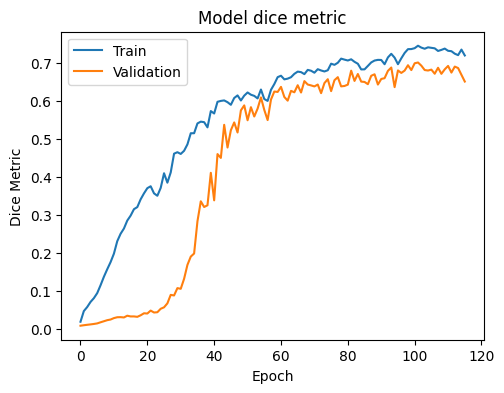

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation dice metric values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['dice_metric'])
plt.plot(history.history['val_dice_metric'])
plt.title('Model dice metric')
plt.xlabel('Epoch')
plt.ylabel('Dice Metric')
plt.legend(['Train', 'Validation'], loc='upper left')



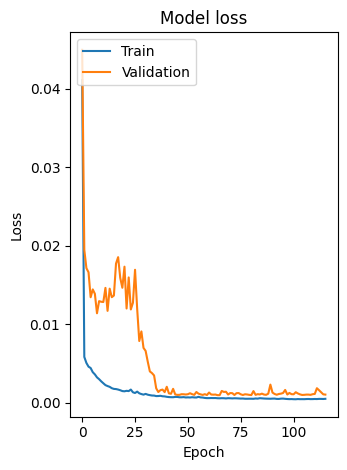

In [ ]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


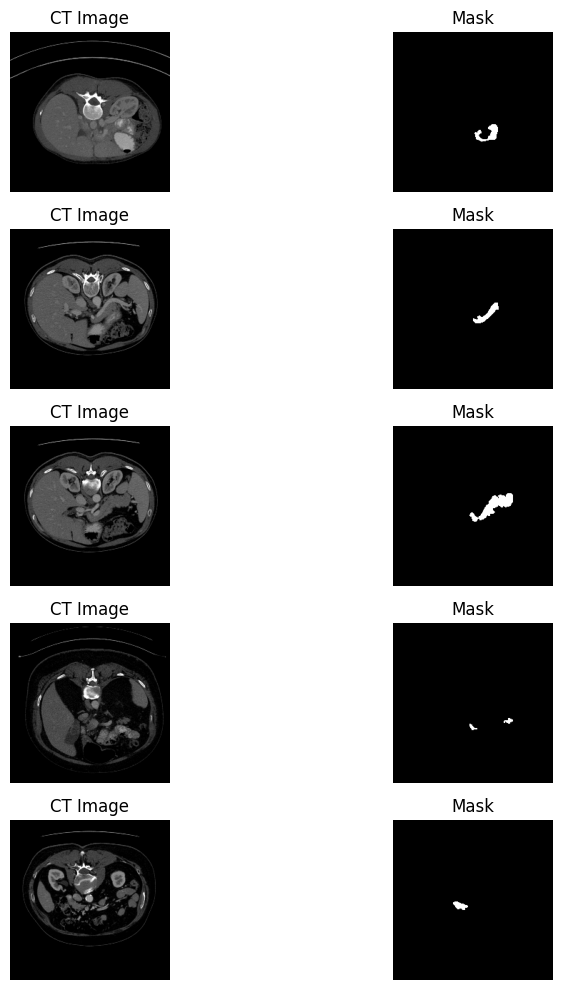

In [ ]:


# Function to visualize images and masks
def visualize_images_and_masks(x_train, y_train, num_images=5):
    plt.figure(figsize=(10, 10))

    for i in range(num_images):
        # Display image
        plt.subplot(num_images, 2, 2 * i + 1)
        plt.imshow(x_train[i], cmap='gray')
        plt.title('CT Image')
        plt.axis('off')

        # Display corresponding mask
        plt.subplot(num_images, 2, 2 * i + 2)
        plt.imshow(y_train[i], cmap='gray')
        plt.title('Mask')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize the first 5 images and masks in the training set
visualize_images_and_masks(x_train, y_train, num_images=5)


In [ ]:
#The shape (504, 224, 224) for x_train indicates that your training dataset contains 504 images, each with dimensions of 224x224 pixels.
print(x_train.shape)

coarse_pred = model.predict(x_train).reshape((len(x_train), 224, 224))


(504, 224, 224)
16/16 [==============================] - 2s 150ms/step


In [ ]:
def lplot_test(index, categorical=False):
    plt.matshow(x_test[index], cmap='gray')
    yp = model.predict(x_test[index].reshape(1, 224, 224))

    if categorical:
        plt.matshow(np.argmax(y_test[index], axis=-1), cmap='gray')
        yp = np.argmax(yp.reshape(224, 224, 2), axis=-1)
    else:
        plt.matshow(y_test[index], cmap='gray')

    plt.matshow(round2binary1(yp.reshape(224, 224)), cmap='gray')


1/1 [==============================] - 0s 23ms/step


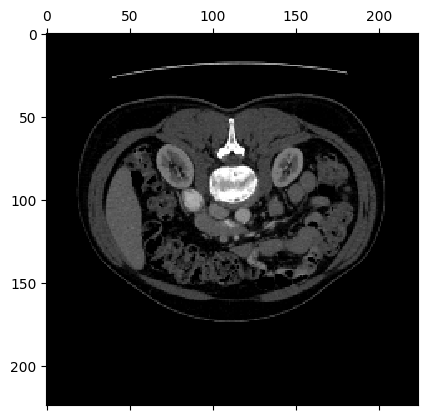

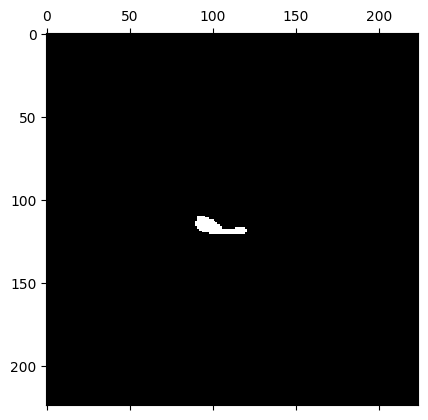

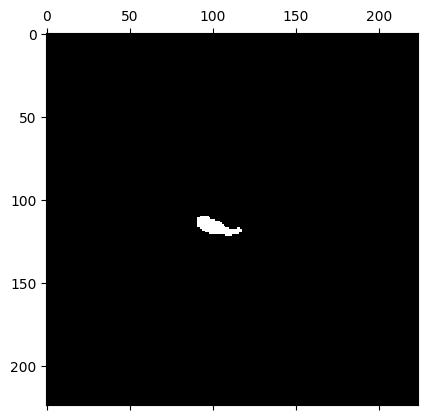

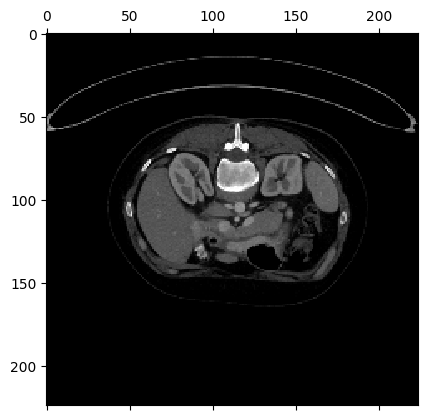

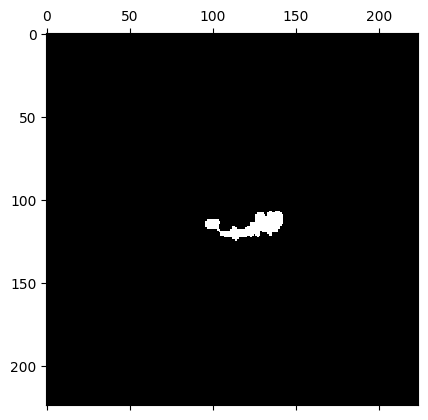

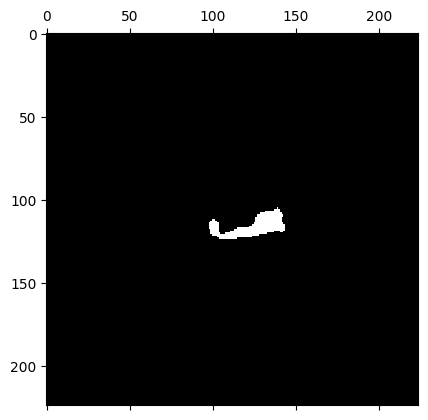

In [ ]:
lplot_test(41)
lplot_test(2)


In [ ]:
print(x_train.shape)

# Fine prediction
fine_pred = model.predict(x_train).reshape((len(x_train), 224, 224))


(504, 224, 224)
16/16 [==============================] - 2s 151ms/step


(504, 224, 224)
1/1 [==============================] - 0s 20ms/step


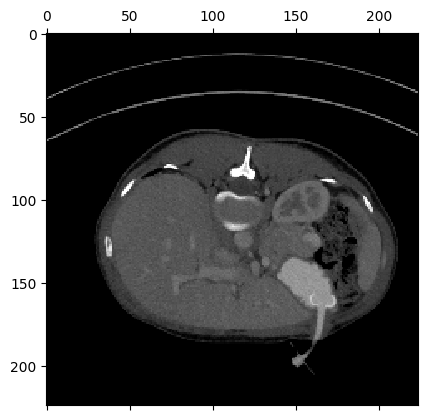

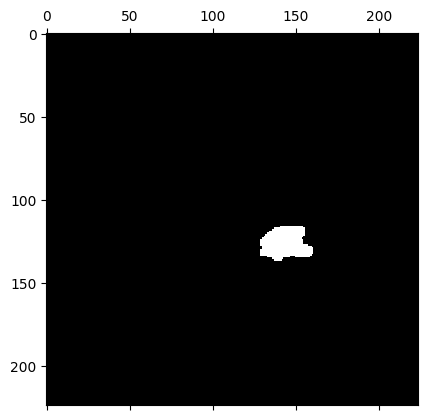

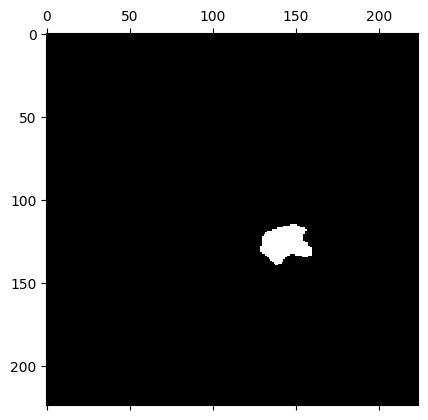

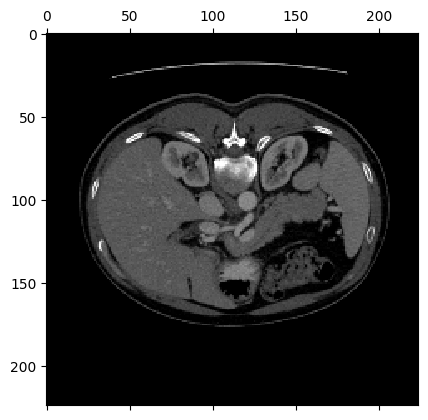

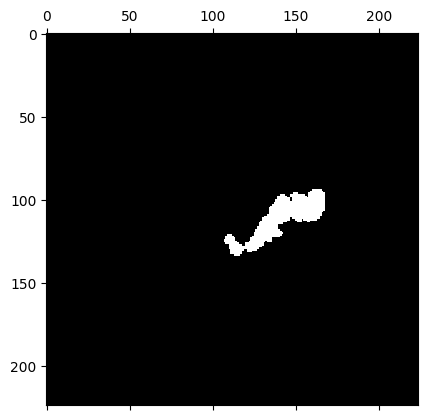

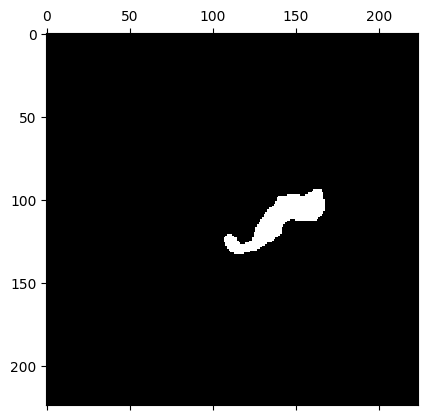

In [ ]:
#checking all at once
print(x_train.shape)

# Coarse prediction
coarse_pred = model.predict(x_train).reshape((len(x_train), 224, 224))

# Fine prediction
fine_pred = model.predict(x_train).reshape((len(x_train), 224, 224))

# Plot test function
def lplot_test(index, categorical=False):
    plt.matshow(x_train[index], cmap='gray')
    yp = model.predict(x_train[index].reshape(1, 224, 224))

    if categorical:
        plt.matshow(np.argmax(y_train[index], axis=-1), cmap='gray')
        yp = np.argmax(yp.reshape(224, 224, 2), axis=-1)
    else:
        plt.matshow(y_train[index], cmap='gray')

    plt.matshow(round2binary1(yp.reshape(224, 224)), cmap='gray')

# Testing the function
lplot_test(41)
lplot_test(2)


#THE FINE PART STARTING

In [ ]:
# Define the directory to save the model
model_dir = '/content/drive/My Drive/pancreas_model'
os.makedirs(model_dir, exist_ok=True)


In [ ]:
# Defining the SMD_Block and single_cell_CASPP here
#

# Encoder
fInput = keras.layers.Input((None, None, 1))
fconv1 = keras.layers.Conv2D(32, 2, 1, padding='same', activation='relu')(fInput)
# Dense Block
fdense1 = SMD_Block(fconv1)
fd_pool1 = keras.layers.MaxPool2D((2, 2))(fdense1)
# End of Dense Block

fconv2 = keras.layers.Conv2D(64, 2, 1, padding='same', activation='relu')(fd_pool1)
fnorm1 = keras.layers.BatchNormalization()(fconv2)
frelu1 = keras.layers.ReLU()(fconv2)
fpool1 = keras.layers.MaxPool2D((2, 2))(frelu1)

# Dense Block
fdense2 = SMD_Block(fpool1)
fd_pool2 = keras.layers.MaxPool2D((2, 2))(fdense2)
# End of Dense Block

fconv3 = keras.layers.Conv2D(64, 2, 1, padding='same', activation='relu')(fd_pool2)
fnorm2 = keras.layers.BatchNormalization()(fconv3)
frelu2 = keras.layers.ReLU()(fconv3)
fpool2 = keras.layers.MaxPool2D((2, 2))(frelu2)

# Bridge (ASPP)
caspp_cell1 = single_cell_CASPP(fpool2, 9, 6, 3)
caspp_cell2 = single_cell_CASPP(fpool2, 6, 3, 1)
caspp_cell3 = single_cell_CASPP(fpool2, 3, 2, 1)
caspp_concat = keras.layers.Concatenate(axis=-1)([caspp_cell1, caspp_cell2, caspp_cell3])
# End of bridge

# Decoder
fupsample1 = keras.layers.UpSampling2D((2, 2))(caspp_concat)
fuconv1 = keras.layers.Conv2DTranspose(64, 2, 1, padding='same', activation='relu')(fupsample1)
funorm1 = keras.layers.BatchNormalization()(fuconv1)
furelu1 = keras.layers.ReLU()(fuconv1)
fskip1 = keras.layers.Concatenate()([frelu2, furelu1])  # skip connection

# Dense Block
fudense1 = SMD_Block(fskip1)
d_up1 = keras.layers.UpSampling2D((2, 2))(fudense1)
# End of dense block

fupsample2 = keras.layers.UpSampling2D((2, 2))(d_up1)

fuconv2 = keras.layers.Conv2DTranspose(64, 2, 1, padding='same', activation='relu')(fupsample2)
funorm2 = keras.layers.BatchNormalization()(fuconv2)
furelu2 = keras.layers.ReLU()(fuconv2)
fskip2 = keras.layers.Concatenate()([frelu1, furelu2])  # skip connection

# Dense Block
fudense2 = SMD_Block(fskip2)
d_up2 = keras.layers.UpSampling2D((2, 2))(fudense2)
# End of dense block

fuconv3 = keras.layers.Conv2DTranspose(32, 2, 1, padding='same', activation='relu')(d_up2)
fskip3 = keras.layers.Concatenate()([fuconv3, fconv1])  # skip connection
# End of Decoder

# Output
fine = keras.layers.Conv2D(1, 1, activation='sigmoid')(fskip3)

In [ ]:
print(caspp_cell1.shape, caspp_cell2.shape, caspp_cell3.shape)


(None, None, None, 3) (None, None, None, 3) (None, None, None, 3)


TRAINING PROCESS

In [ ]:
from sklearn.model_selection import train_test_split


In [ ]:
# Define dice loss
def dice_loss(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - ((2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.))


In [ ]:
# Define jaccard loss
def jaccard_loss(y_true, y_pred, smooth=100):
    """ Calculates mean of Jaccard distance as a loss function """
    intersection = tf.reduce_sum(y_true * y_pred, axis=(1, 2))
    sum_ = tf.reduce_sum(y_true + y_pred, axis=(1, 2))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    jd = (1 - jac) * smooth
    return tf.reduce_mean(jd)

In [ ]:
# Define dice metric (assuming it's similar to dice loss)
def dice_metric(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)



In [ ]:
# EAD model fit function with model saving
def ead_model_fit(data, truth, loss='binary_focal_crossentropy', save_path=None):
    fmodel = keras.models.Model(inputs=fInput, outputs=fine)
    fmodel.compile(loss=loss, optimizer='adam', metrics=[dice_metric, keras.metrics.Precision(), keras.metrics.Recall()])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(save_path, save_best_only=True, monitor='val_loss')
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

    # Train the model
    history = fmodel.fit(data, truth, epochs=100, validation_data=(x_test, y_test), callbacks=[early_stopping, model_checkpoint, reduce_lr])

    return fmodel, history

In [ ]:
print(coarse_pred.shape)


(504, 224, 224)


In [ ]:
# i trained and saved models with different loss functions
print('\n\nFOCAL LOSS\n\n')
model1, history1 = ead_model_fit(coarse_pred, y_train, save_path=os.path.join(model_dir, 'model1.h5'))

print('\n\nDICE LOSS\n\n')
model2, history2 = ead_model_fit(coarse_pred, y_train, loss=dice_loss, save_path=os.path.join(model_dir, 'model2.h5'))

print('\n\nCROSSENTROPY LOSS\n\n')
model3, history3 = ead_model_fit(coarse_pred, y_train, loss='binary_crossentropy', save_path=os.path.join(model_dir, 'model3.h5'))

print('\n\nJACCARD LOSS\n\n')
model4, history4 = ead_model_fit(coarse_pred, y_train, loss=jaccard_loss, save_path=os.path.join(model_dir, 'model4.h5'))


# Saving model in HDF5 format.keras
# Save model1, model2, model3, model4 using model.save()
model1.save(os.path.join(model_dir, 'model1.h5'))
model2.save(os.path.join(model_dir, 'model2.h5'))
model3.save(os.path.join(model_dir, 'model3.h5'))
model4.save(os.path.join(model_dir, 'model4.h5'))




FOCAL LOSS


Epoch 1/100
16/16 [==============================] - 26s 831ms/step - loss: 0.1074 - dice_metric: 0.0053 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.0256 - val_dice_metric: 0.0018 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 2/100
16/16 [==============================] - 11s 691ms/step - loss: 0.0125 - dice_metric: 0.0092 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00 - val_loss: 0.0095 - val_dice_metric: 0.0166 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - lr: 0.0010
Epoch 3/100
16/16 [==============================] - 11s 683ms/step - loss: 0.0025 - dice_metric: 0.1512 - precision_2: 0.7653 - recall_2: 0.4883 - val_loss: 0.0238 - val_dice_metric: 0.0337 - val_precision_2: 0.0061 - val_recall_2: 0.0474 - lr: 0.0010
Epoch 4/100
16/16 [==============================] - 11s 675ms/step - loss: 7.6150e-04 - dice_metric: 0.5577 - precision_2: 0.8504 - recall_2: 0.8781 - val_loss: 0.0397 - val_dice_metric: 0.0333

In [ ]:
#Checking the Testing set for the fine part
test_loss, test_dice, test_precision, test_recall, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Dice: {test_dice}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")


11/11 [==============================] - 2s 150ms/step - loss: 9.6399e-04 - dice_metric: 0.6424 - precision_1: 0.8667 - recall_1: 0.8259 - accuracy: 2.1881e-06
Test Loss: 0.0009639887721277773
Test Dice: 0.6424234509468079
Test Precision: 0.866706132888794
Test Recall: 0.8259133696556091


In [ ]:
# MAJORITY VOTE
def majority_vote(data):
    a = round2binary1(model1.predict(data))
    b = round2binary1(model2.predict(data))
    c = round2binary1(model3.predict(data))
    d = round2binary1(model4.predict(data))

    voted = a + b + c + d
    print('hey', np.unique(a))
    voted[voted < 2] = 0
    voted[voted >= 2] = 1

    return voted


In [ ]:
#A higher Dice score (closer to 1.0) indicates better agreement between predicted and true segmentation masks
np.max(model4.predict(coarse_pred))


16/16 [==============================] - 3s 148ms/step


1.0

In [ ]:
np.max(model4.predict(coarse_pred))


16/16 [==============================] - 2s 148ms/step


1.0

In [ ]:
#  existing code for fine predictions. I have already but just wanted to repeat
fine_pred = model.predict(x_train).reshape((len(x_train), 224, 224))

16/16 [==============================] - 2s 150ms/step


In [ ]:
# Ensembling VOTE ALGORITHM
a = np.array([0, 0, 1, 1]) + np.array([0, 0, 0, 1]) + np.array([0, 0, 0, 1])
a[a / 2 < 1] = 0
a[a / 2 >= 1] = 1

# FUNCTION FOR CALCULATING DICE SCORE WITH BINARIZED IMAGES
# Binarized here means we are converting the pixel values from an analog-like sigmoid representation to discrete binary (1 and 0)
def dice_binarized(pred, true, k=1):  # k is the value of the prediction
    binarized = round2binary1(pred)  # binarizing image
    pred = binarized.flatten()
    true = true.flatten()
    # DICE CALC
    intersection = np.sum(pred[true == k]) * 2.0
    if intersection == 0:  # This if statement means that the function returns 1 for images where the pancreas is not visible
        return 0.5  # All predictions where the pancreas is not visible would be removed in the subsequent cells
    dice = intersection / (np.sum(pred) + np.sum(true))
    # end
    return dice


In [ ]:
#a function to calculate accuracy based on the binarized predictions and the ground truth
def calculate_accuracy(y_true, y_pred):
    y_pred_binary = round2binary1(y_pred)
    correct_predictions = np.sum(y_true == y_pred_binary)
    total_predictions = y_true.size
    accuracy = correct_predictions / total_predictions
    return accuracy


In [ ]:
# Calculate accuracy for binarized fine predictions
fine_pred_binary = round2binary1(fine_pred)
accuracy = calculate_accuracy(y_train, fine_pred_binary)
print(f"Accuracy for fine predictions: {accuracy}")


Accuracy for fine predictions: 0.999112133227547


In [ ]:
# Plot test function
def lplot_test(index, categorical=False):
    plt.matshow(x_train[index], cmap='gray')
    yp = model.predict(x_train[index].reshape(1, 224, 224))

    if categorical:
        plt.matshow(np.argmax(y_train[index], axis=-1), cmap='gray')
        yp = np.argmax(yp.reshape(224, 224, 2), axis=-1)
    else:
        plt.matshow(y_train[index], cmap='gray')

    plt.matshow(round2binary1(yp.reshape(224, 224)), cmap='gray')

1/1 [==============================] - 0s 22ms/step


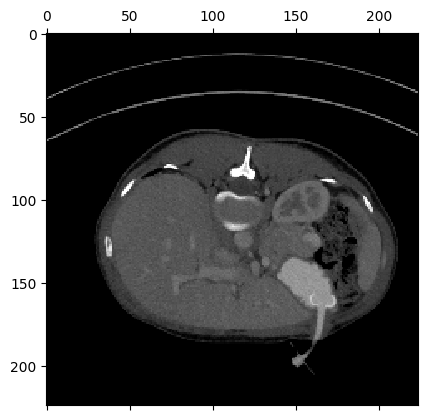

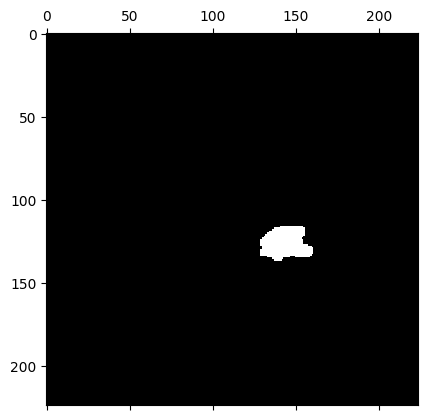

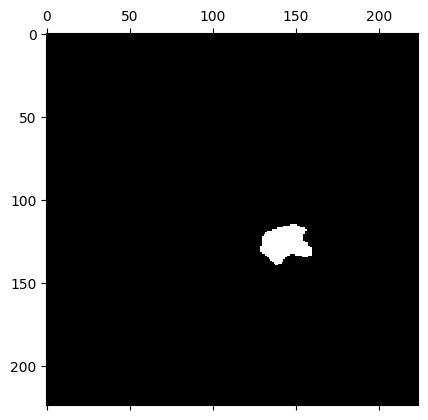

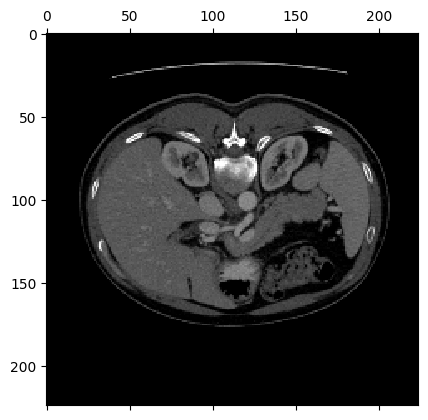

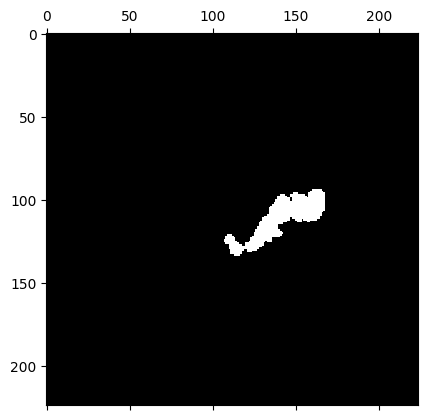

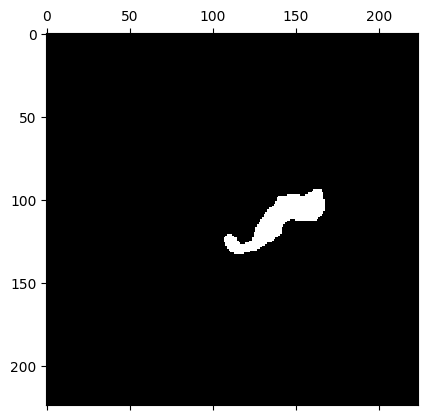

In [ ]:
# Testing the function
lplot_test(41)
lplot_test(2)

In [ ]:
# Mount Google Drive (if not already mounted)
from google.colab import drive
drive.mount('/content/drive')

# Define the directory where models are saved
model_dir = '/content/drive/My Drive/pancreas_model'

# List all files in the directory to verify
os.listdir(model_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['model2.h5',
 'model3.h5',
 'model4.h5',
 'best_model_attention.h5',
 'model1.h5',
 'best_model.h5']